In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib tk
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [2]:
# device = torch.device("cuda:1")
device = torch.device("cpu")

## 1D regression dataset

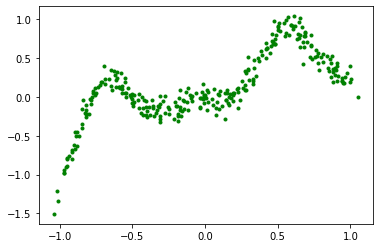

In [3]:
class Dataset2Dregression:
    def __init__(self):
        np.random.seed(12)
        x = np.linspace(0,1,300)
        noise = np.random.normal(0,0.02, x.shape)
        x = x + noise
        x = np.sort(x)

        y= (2 * np.sin(10*x) + np.cos(20 * x - 3) + 3 * np.log(10*x + 0.5) - 4)/6.
        noise = np.random.normal(0,0.1, x.shape)
        y = y + noise

        x = x*2
        x = x - x.mean() # good practice to zero-center x in linear mapping
        self.xx = torch.Tensor(x.reshape(-1,1))
        self.yy = torch.Tensor(y.reshape(-1,1))
        self.xy = torch.cat([self.xx, self.yy], dim=-1)
        pass
        
    def sample(self, n):
        assert n <= len(self.xx)
        rand_idx = torch.randperm(len(self.xx))[:n]
        
        return self.xy[rand_idx]

dataset = Dataset2Dregression()
x, y = dataset.xy[:,0], dataset.xy[:,1]

%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.show()

## Train Contrastive Model

In [4]:
import dtnnlib as dtnn

In [27]:
class EnergyModel(nn.Module):
    
    def __init__(self, dim, n_components):
        super().__init__()
        self.dt = dtnn.DistanceTransformBase(dim, n_components)
        self.dt.centers.data = torch.rand_like(self.dt.centers)*3-1.5
        
        self.scale = nn.Parameter(torch.zeros(1, n_components))
        
        self.actf = dtnn.OneActiv(n_components, mode='exp_1.6', max_similarity=0)
        
        self.weight = nn.Parameter(torch.randn(n_components, 1))
        
    def forward(self, x):
        self.weight.data = self.weight.data.abs()
#         self.weight.data = self.weight.data / torch.sum(self.weight.data)
        
        x = self.dt(x)
        x = x * torch.exp(self.scale)
        
        x = self.actf(-x)
#         return x.mean(dim=-1, keepdim=True)
        x = x@self.weight
    
#         x = x.mean(dim=-1, keepdim=True)*10 - 5
#         return torch.sigmoid(x-self.weight.data.mean())
        return torch.sigmoid(x-2)

In [28]:
model = EnergyModel(2, 10)
model(torch.randn(5, 2))

tensor([[0.4002],
        [0.4613],
        [0.4961],
        [0.1528],
        [0.4391]], grad_fn=<SigmoidBackward>)

In [29]:
# model.weight

In [30]:
# model = nn.Sequential(
#     nn.Linear(2, 100),
#     nn.ELU(),
#     nn.Linear(100, 1),
#     nn.Sigmoid(),
# )

In [31]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [32]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(111)

N = 200
for i in range(1000):
    xpos = dataset.sample(N)
    ypos = torch.ones(N, 1)
    xneg = torch.cat([torch.rand(N,1)*3-1.5, torch.rand(N,1)*3-1.7], dim=-1)
    yneg = torch.zeros(N, 1)
    
    e_pos = model(xpos)
    e_neg = model(xneg)
    
    error = criterion(e_pos, ypos) + criterion(e_neg, yneg)
    
#     error = (e_pos - e_neg).mean()
    
#     error = (e_pos - e_neg) + 0.1 * (e_pos ** 2 + e_neg ** 2)
#     error = error.mean()
        
    optimizer.zero_grad()
    error.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
    optimizer.step()
    
    if i%100 == 0:
        accu = (e_pos > 0.5).type(torch.float).mean()*0.5+(e_neg < 0.5).type(torch.float).mean()*0.5
        print(f"Step: {i}, E: {error:.6f}, Acc: {accu}")
        
        ax.clear()
        ax.scatter(dataset.xy[:,0], dataset.xy[:,1], marker='.', color='g')
        ax.scatter(xneg[:,0], xneg[:,1], marker='.', color='r')
#         ax.scatter(model.dt.centers[:,0].data, model.dt.centers[:,1].data, marker='.', color='b')

        fig.canvas.draw()
        plt.pause(0.01)
plt.close()



# for i_epoch in range(args.n_epoch):
#     l_loss = []
#     for pos_x, in train_dl:
        
#         pos_x = pos_x.cuda()
        
#         neg_x = torch.randn_like(pos_x)
#         neg_x = sample_langevin(neg_x, model, args.stepsize, args.n_steps, intermediate_samples=False)
        
#         opt.zero_grad()
#         pos_out = model(pos_x)
#         neg_out = model(neg_x)
        
#         loss = (pos_out - neg_out) + args.alpha * (pos_out ** 2 + neg_out ** 2)
#         loss = loss.mean()
#         loss.backward()
        
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
#         opt.step()
        
#         l_loss.append(loss.item())
#     print(np.mean(l_loss))

Step: 0, E: 1.508136, Acc: 0.6225000023841858
Step: 100, E: 0.911695, Acc: 0.8224999904632568
Step: 200, E: 0.720905, Acc: 0.8799999952316284
Step: 300, E: 0.806359, Acc: 0.8524999618530273
Step: 400, E: 0.697820, Acc: 0.8849999904632568
Step: 500, E: 0.765316, Acc: 0.8524999618530273
Step: 600, E: 0.807546, Acc: 0.8575000166893005
Step: 700, E: 0.761700, Acc: 0.8474999666213989
Step: 800, E: 0.767140, Acc: 0.8550000190734863
Step: 900, E: 0.742610, Acc: 0.8774999976158142


In [33]:
xx, yy = torch.meshgrid([torch.linspace(-1.2, 1.2, 50), torch.linspace(-1.6, 1.1, 50)])
xx.shape, yy.shape

(torch.Size([50, 50]), torch.Size([50, 50]))

In [34]:
xx = xx.reshape(-1, 1)
yy = yy.reshape(-1, 1)
xxyy = torch.cat([xx, yy], dim=-1)
xxyy.shape

torch.Size([2500, 2])

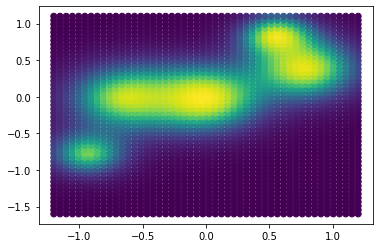

In [35]:
out = model(xxyy).data

%matplotlib inline
plt.scatter(xxyy[:,0], xxyy[:,1], c=out.reshape(-1))

In [36]:
asdfdsf

NameError: name 'asdfdsf' is not defined

### Optimize for best Y given the X

In [37]:
x = dataset.xy[:,:1]
# y = torch.autograd.Variable(torch.zeros_like(x), requires_grad=True)
y = torch.autograd.Variable(torch.randn_like(x)*0.3, requires_grad=True)

In [38]:
xy = torch.cat([x, y], dim=-1)
xy.requires_grad

True

In [39]:
optimizer = optim.Adam([y], lr=0.001)

In [40]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(1000):
    xy = torch.cat([x, y], dim=-1)
    error = -model(xy).mean()
    optimizer.zero_grad()
    error.backward(retain_graph=True)
    optimizer.step()
    
    if i%100 == 0:
        print(f"Step: {i}, E: {error:.6f}")
        
        ax.clear()
        ax.scatter(x, y.data, marker='.', color='r')
        ax.scatter(dataset.xy[:,0], dataset.xy[:,1], marker='.', color='g')

        fig.canvas.draw()
        plt.pause(0.01)
plt.close()

Step: 0, E: -0.580302
Step: 100, E: -0.662268
Step: 200, E: -0.735345
Step: 300, E: -0.789570
Step: 400, E: -0.819550
Step: 500, E: -0.832636
Step: 600, E: -0.837070
Step: 700, E: -0.839120
Step: 800, E: -0.839686
Step: 900, E: -0.840059


In [41]:
y.grad

tensor([[-5.8208e-11],
        [ 7.3222e-07],
        [ 2.9104e-11],
        [-1.4552e-10],
        [-1.4552e-11],
        [ 1.4552e-11],
        [-5.2154e-08],
        [ 2.4047e-07],
        [-7.2760e-11],
        [ 0.0000e+00],
        [ 3.6604e-07],
        [ 4.3656e-11],
        [-1.4552e-11],
        [ 7.3051e-08],
        [-4.3656e-11],
        [-1.0186e-10],
        [-1.4552e-11],
        [ 8.7311e-11],
        [-1.1642e-10],
        [-3.4925e-10],
        [-1.0186e-10],
        [-2.2352e-08],
        [ 0.0000e+00],
        [-1.4552e-11],
        [ 4.8833e-07],
        [ 1.4744e-07],
        [ 2.3944e-07],
        [-1.5876e-08],
        [ 9.4587e-11],
        [ 2.2352e-08],
        [-5.0932e-11],
        [ 1.5350e-06],
        [-2.2410e-09],
        [ 3.6380e-11],
        [-1.0383e-08],
        [-1.4901e-08],
        [ 1.2884e-07],
        [-6.5775e-09],
        [ 2.9104e-11],
        [ 7.2760e-12],
        [-4.3656e-11],
        [ 9.4600e-06],
        [ 0.0000e+00],
        [-6

In [42]:
# %matplotlib inline
# plt.scatter(x, y, marker='.', color='g')
# plt.scatter(x, YY.data, marker='.', color='r')
# plt.show()

## Multi-Layered Energy Based Model

In [75]:
class LayeredEnergyModel(nn.Module):
    
    def __init__(self, dim, n_components):
        super().__init__()
        self.scale_x = nn.Parameter(torch.zeros(1, dim))

        self.dt = dtnn.DistanceTransformBase(dim, n_components)
        self.dt.centers.data = torch.rand_like(self.dt.centers)*3-1.5
        
        self.scale_y = nn.Parameter(torch.zeros(1, n_components))
        
        self.actf = dtnn.OneActiv(n_components, mode='exp_1.6', max_similarity=0)
        
        self.weight = nn.Parameter(torch.randn(n_components, 1))
        
    def forward(self, x):
        x = x * torch.exp(self.scale_x)
        x = self.dt(x)
        x = x * torch.exp(self.scale_y)
        
#         x = self.actf(-x)
        return x

    def energy(self, x):
        self.weight.data = self.weight.data.abs()
#         self.weight.data = self.weight.data / torch.sum(self.weight.data)
        
        x = x * torch.exp(self.scale_x)
        x = self.dt(x)
        x = x * torch.exp(self.scale_y)
        
        x = self.actf(-x)
        
        x = x@self.weight
        
#         x = x.mean(dim=-1, keepdim=True)*10 - 5
        return torch.sigmoid(x-2)

In [76]:
layer_1 = LayeredEnergyModel(2, 10)

In [77]:
optimizer = optim.Adam(layer_1.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [78]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(111)

N = 200
for i in range(2000):
    xpos = dataset.sample(N)
    ypos = torch.ones(N, 1)
    xneg = torch.cat([torch.rand(N,1)*3-1.5, torch.rand(N,1)*3-1.7], dim=-1)
    yneg = torch.zeros(N, 1)
    
    e_pos = layer_1.energy(xpos)
    e_neg = layer_1.energy(xneg)
    
    error = criterion(e_pos, ypos) + criterion(e_neg, yneg)
    
    optimizer.zero_grad()
    error.backward()
    torch.nn.utils.clip_grad_norm_(layer_1.parameters(), max_norm=1)
    optimizer.step()
    
    if i%100 == 0:
        accu = (e_pos > 0.5).type(torch.float).mean()*0.5+(e_neg < 0.5).type(torch.float).mean()*0.5
        print(f"Step: {i}, E: {error:.6f}, Acc: {accu}")
        
        ax.clear()
        ax.scatter(dataset.xy[:,0], dataset.xy[:,1], marker='.', color='g')
        ax.scatter(xneg[:,0], xneg[:,1], marker='.', color='r')
#         ax.scatter(model.dt.centers[:,0].data, model.dt.centers[:,1].data, marker='.', color='b')

        fig.canvas.draw()
        plt.pause(0.01)
plt.close()

Step: 0, E: 1.218362, Acc: 0.6725000143051147
Step: 100, E: 0.749362, Acc: 0.8925000429153442
Step: 200, E: 0.704013, Acc: 0.887499988079071
Step: 300, E: 0.662184, Acc: 0.9025000333786011
Step: 400, E: 0.574593, Acc: 0.9275000095367432
Step: 500, E: 0.655760, Acc: 0.8924999833106995
Step: 600, E: 0.692049, Acc: 0.8925000429153442
Step: 700, E: 0.605168, Acc: 0.9024999737739563
Step: 800, E: 0.653690, Acc: 0.9049999713897705
Step: 900, E: 0.629369, Acc: 0.8899999856948853
Step: 1000, E: 0.615636, Acc: 0.9024999737739563
Step: 1100, E: 0.640813, Acc: 0.8999999761581421
Step: 1200, E: 0.599810, Acc: 0.8999999761581421
Step: 1300, E: 0.523596, Acc: 0.9350000023841858
Step: 1400, E: 0.593659, Acc: 0.9125000238418579
Step: 1500, E: 0.635244, Acc: 0.9125000238418579
Step: 1600, E: 0.533169, Acc: 0.9424999952316284
Step: 1700, E: 0.532461, Acc: 0.9275000095367432
Step: 1800, E: 0.598214, Acc: 0.9099999666213989
Step: 1900, E: 0.517721, Acc: 0.9175000190734863


In [79]:
xx, yy = torch.meshgrid([torch.linspace(-1.2, 1.2, 50), torch.linspace(-1.6, 1.1, 50)])
xx.shape, yy.shape

(torch.Size([50, 50]), torch.Size([50, 50]))

In [80]:
xx = xx.reshape(-1, 1)
yy = yy.reshape(-1, 1)
xxyy = torch.cat([xx, yy], dim=-1)
xxyy.shape

torch.Size([2500, 2])

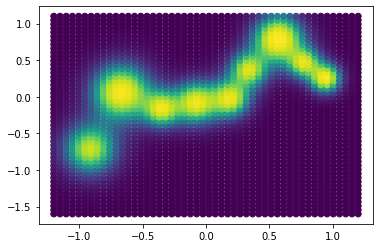

In [81]:
out = layer_1.energy(xxyy).data

%matplotlib inline
plt.scatter(xxyy[:,0], xxyy[:,1], c=out.reshape(-1))

#### Add layer 2 of Energy Model

In [84]:
layer_2 = LayeredEnergyModel(12, 10)

In [85]:
optimizer = optim.Adam(layer_2.parameters(), lr=0.003)
criterion = nn.BCELoss()

In [87]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(111)

N = 200
for i in range(2000):
    with torch.no_grad():
        xpos = dataset.sample(N)
        xneg = torch.cat([torch.rand(N,1)*3-1.5, torch.rand(N,1)*3-1.7], dim=-1)

        xpos = torch.cat([xpos, layer_1(xpos)], dim=-1)
        xneg = torch.cat([xneg, layer_1(xneg)], dim=-1)
    
        ypos = torch.ones(N, 1)
        yneg = torch.zeros(N, 1)
    
    e_pos = layer_2.energy(xpos)
    e_neg = layer_2.energy(xneg)
    
    error = criterion(e_pos, ypos) + criterion(e_neg, yneg)
    
    optimizer.zero_grad()
    error.backward()
    torch.nn.utils.clip_grad_norm_(layer_2.parameters(), max_norm=1)
    optimizer.step()
    
    if i%100 == 0:
        accu = (e_pos > 0.5).type(torch.float).mean()*0.5+(e_neg < 0.5).type(torch.float).mean()*0.5
        print(f"Step: {i}, E: {error:.6f}, Acc: {accu}")
        
        ax.clear()
        ax.scatter(dataset.xy[:,0], dataset.xy[:,1], marker='.', color='g')
        ax.scatter(xneg[:,0], xneg[:,1], marker='.', color='r')
#         ax.scatter(model.dt.centers[:,0].data, model.dt.centers[:,1].data, marker='.', color='b')

        fig.canvas.draw()
        plt.pause(0.01)
plt.close()

Step: 0, E: 0.606869, Acc: 0.9125000238418579
Step: 100, E: 0.570572, Acc: 0.9125000238418579
Step: 200, E: 0.640152, Acc: 0.887499988079071
Step: 300, E: 0.653556, Acc: 0.8999999761581421
Step: 400, E: 0.554865, Acc: 0.9275000095367432
Step: 500, E: 0.581153, Acc: 0.9175000190734863
Step: 600, E: 0.697294, Acc: 0.8799999952316284
Step: 700, E: 0.595829, Acc: 0.9049999713897705
Step: 800, E: 0.635864, Acc: 0.8975000381469727
Step: 900, E: 0.637461, Acc: 0.8949999809265137
Step: 1000, E: 0.559948, Acc: 0.9225000143051147
Step: 1100, E: 0.652533, Acc: 0.8949999809265137
Step: 1200, E: 0.643075, Acc: 0.8824999928474426
Step: 1300, E: 0.700762, Acc: 0.8799999952316284
Step: 1400, E: 0.590015, Acc: 0.9149999618530273
Step: 1500, E: 0.656235, Acc: 0.8925000429153442
Step: 1600, E: 0.559177, Acc: 0.9249999523162842
Step: 1700, E: 0.627964, Acc: 0.9049999713897705
Step: 1800, E: 0.693120, Acc: 0.8949999809265137
Step: 1900, E: 0.582502, Acc: 0.9125000238418579


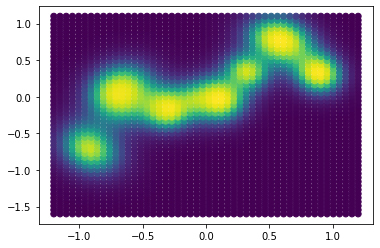

In [88]:
data = torch.cat([xxyy, layer_1(xxyy)], dim=-1)
out = layer_2.energy(data).data

%matplotlib inline
plt.scatter(xxyy[:,0], xxyy[:,1], c=out.reshape(-1))

### Optimize for best Y given the X

In [107]:
x = dataset.xy[:,:1]
# y = torch.autograd.Variable(torch.zeros_like(x), requires_grad=True)
y = torch.autograd.Variable(torch.randn_like(x)*0.3, requires_grad=True)

In [108]:
# xy = torch.cat([x, y], dim=-1)
# xy.requires_grad

In [109]:
optimizer = optim.Adam([y], lr=0.001)

In [110]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(2000):
    xy = torch.cat([x, y], dim=-1)
    
    out = layer_1.energy(xy)
    xy = torch.cat([xy, layer_1(xy).data], dim=-1)
    out = out + layer_2.energy(xy)

    error = -out.mean()
    
    optimizer.zero_grad()
    error.backward()
    optimizer.step()
    
    if i%100 == 0:
        print(f"Step: {i}, E: {error:.6f}")
        
        ax.clear()
        ax.scatter(x, y.data, marker='.', color='r')
        ax.scatter(dataset.xy[:,0], dataset.xy[:,1], marker='.', color='g')

        fig.canvas.draw()
        plt.pause(0.01)
plt.close()

Step: 0, E: -0.999628
Step: 100, E: -1.198949
Step: 200, E: -1.412148
Step: 300, E: -1.601635
Step: 400, E: -1.702252
Step: 500, E: -1.751834
Step: 600, E: -1.766673
Step: 700, E: -1.771487
Step: 800, E: -1.775881
Step: 900, E: -1.781061
Step: 1000, E: -1.782289
Step: 1100, E: -1.782323
Step: 1200, E: -1.782311
Step: 1300, E: -1.782296
Step: 1400, E: -1.782293
Step: 1500, E: -1.782369
Step: 1600, E: -1.782850
Step: 1700, E: -1.783138
Step: 1800, E: -1.783160
Step: 1900, E: -1.783161
